<a href="https://colab.research.google.com/github/HUMINTING/callte-detetion-detail/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/mt_detection/20230111')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=b0bc68bdab96e2ea223caccfe8f597411f70fa5373bb50632212b149cbb71955
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built pretrainedmodels


In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from my_nn import MyNetBase, MyNetMultiTask, MyNetMultiTask_change_model, MyNetMultiTask_devide_hip_head, MyNetMultiTask_devide_hip_direction, MyNetMultiTask_devide_hip_direction_hierarchical


In [ ]:

BATCH_SIZE = 32

In [ ]:
 model_ft = MyNetBase('desn')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
 model_ft

MyNetBase(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models
#from effnetv2 import effnetv2_s
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np

 
# 设置超参数
 
BATCH_SIZE = 32
EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
# 数据预处理
 
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomCrop(50),
    # transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
 
])
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
# 读取数据
dataset_train = datasets.ImageFolder('/content/drive/MyDrive/data/1/train', transform)
print(dataset_train.imgs)
# 对应文件夹的label
print(dataset_train.class_to_idx)
dataset_test = datasets.ImageFolder('/content/drive/MyDrive/data/1/valid', transform_test)
# 对应文件夹的label
print(dataset_test.class_to_idx)
 
# 导入数据
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
modellr = 1e-4
 
# 实例化模型并且移动到GPU
criterion = nn.CrossEntropyLoss()
# model = effnetv2_s()
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, 2)
model_ft = MyNetBase('densenet')
model_ft.to(DEVICE)
# 选择简单暴力的Adam优化器，学习率调低
optimizer = optim.Adam(model_ft.parameters(), lr=modellr)
 
 
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    modellrnew = modellr * (0.1 ** (epoch // 50))
    print("lr:", modellrnew)
    for param_group in optimizer.param_groups:
        param_group['lr'] = modellrnew

train_losses = []
train_acces = []
eval_losses = []
eval_acces = []
# 定义训练过程
 
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    sum_loss = 0
    correct = 0
    total_num = len(train_loader.dataset)
    print(total_num, len(train_loader))
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print_loss = loss.data.item()
        sum_loss += print_loss
        _, pred = torch.max(output.data, 1)
        correct += torch.sum(pred == target)
        correct = correct.data.item()
        train_acc = correct / total_num
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                       100. * (batch_idx + 1) / len(train_loader), loss.item()))
    ave_loss = sum_loss / len(train_loader)
    train_losses.append(ave_loss)
    train_acces.append(train_acc)
    print('epoch:{},loss:{}'.format(epoch, ave_loss))
 
 

def val(model, device, test_loader):
     model.eval()
     test_loss = 0
     correct = 0
     total_num = len(test_loader.dataset)
     print(total_num, len(test_loader))
     with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data).to(device), Variable(target).to(device)
            output = model(data)
            loss = criterion(output, target)
            _, pred = torch.max(output.data, 1)
            correct += torch.sum(pred == target)
            print_loss = loss.data.item()
            test_loss += print_loss
        correct = correct.data.item()
        acc = correct / total_num
        avgloss = test_loss / len(test_loader)
        eval_losses.append(avgloss)
        eval_acces.append(acc)
        print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            avgloss, correct, len(test_loader.dataset), 100 * acc))
      

 
# 训练
 
for epoch in range(1, EPOCHS + 1):
    adjust_learning_rate(optimizer, epoch)
    train(model_ft, DEVICE, train_loader, optimizer, epoch)
   # val(model_ft, DEVICE, test_loader)
    plt.plot(np.arange(len(train_losses)), train_losses,label="train loss")

    plt.plot(np.arange(len(train_acces)), train_acces, label="train acc")
    #plt.plot(np.arange(len(eval_losses)), eval_losses, label="valid loss")
    #plt.plot(np.arange(len(eval_acces)), eval_acces, label="valid acc")
    plt.legend() #显示图例
    plt.xlabel('epoches')
    plt.ylabel("epoch")
    plt.title('Model accuracy&loss')
    plt.show()
torch.save(model_ft.state_dict(),'/content/drive/MyDrive/mt_detection/20230111/model_densenet_100.pth' )

FileNotFoundError: ignored

In [ ]:
len(dataset_train)

3472

In [ ]:
len(dataset_test)

1140

 # モデル等セットアップ


In [ ]:
 model_ft = MyNetBase('densenet161')
 weights_path = '/content/drive/MyDrive/mt_detection/20230105/model_densenet.pth'
 if torch.cuda.is_available():  
    device = torch.device('cuda:0')
 else:
    device = torch.device('gpu')
 model_ft.load_state_dict(torch.load(weights_path, map_location=device))
 model_ft = model_ft.to(device)


RuntimeError: ignored

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomCrop(50),
    # transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
 
])
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
# 读取数据
dataset_train = datasets.ImageFolder('/content/drive/MyDrive/data/1/train', transform)
print(dataset_train.imgs)
# 对应文件夹的label
print(dataset_train.class_to_idx)
print(len(dataset_train))
dataset_test = datasets.ImageFolder('/content/drive/MyDrive/data/1/test', transform_test)
# 对应文件夹的label
print(dataset_test.class_to_idx)
print(len(dataset_test))
# 导入数据
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)


[('/content/drive/MyDrive/data/1/train/garbage/estrus_data_one_1_20160706_1800_ch1_0208_02.png', 0), ('/content/drive/MyDrive/data/1/train/garbage/estrus_data_one_1_20160706_1800_ch1_0444_03.png', 0), ('/content/drive/MyDrive/data/1/train/garbage/estrus_data_one_1_20160706_1800_ch1_0445_03.png', 0), ('/content/drive/MyDrive/data/1/train/garbage/estrus_data_one_1_20160706_1800_ch1_0447_04.png', 0), ('/content/drive/MyDrive/data/1/train/garbage/estrus_data_one_1_20160706_1800_ch1_0769_06.png', 0), ('/content/drive/MyDrive/data/1/train/garbage/estrus_data_one_1_20160706_1800_ch1_0772_06.png', 0), ('/content/drive/MyDrive/data/1/train/garbage/estrus_data_one_1_20160706_1800_ch1_0773_06.png', 0), ('/content/drive/MyDrive/data/1/train/garbage/estrus_data_one_1_20160706_1800_ch1_0773_07.png', 0), ('/content/drive/MyDrive/data/1/train/garbage/estrus_data_one_1_20160706_1800_ch1_0774_04.png', 0), ('/content/drive/MyDrive/data/1/train/garbage/estrus_data_one_1_20160706_1800_ch1_0791_07.png', 0),

In [ ]:
def get_confusion_matrix(trues, preds):
  labels = {'garbage': 0, 'mt': 1, 'multiple': 2, 'one': 3}
  conf_matrix = confusion_matrix(trues, preds)
  return conf_matrix
  
def plot_confusion_matrix(conf_matrix):
  plt.imshow(conf_matrix, cmap=plt.cm.Greens)
  indices = range(conf_matrix.shape[0])
  labels = [0,1,2,3]
  plt.xticks(indices, labels)
  plt.yticks(indices, labels)
  plt.colorbar()
  plt.xlabel('y_pred')
  plt.ylabel('y_true')
  # 显示数据
  for first_index in range(conf_matrix.shape[0]):
    for second_index in range(conf_matrix.shape[1]):
      plt.text(first_index, second_index, conf_matrix[first_index, second_index])
  plt.savefig('heatmap_confusion_matrix.jpg')
  plt.show()

              precision    recall  f1-score   support

           0       0.00      0.25      0.00         4
           1       0.20      0.27      0.23       141
           2       0.58      0.10      0.17       442
           3       1.00      0.01      0.02       335

    accuracy                           0.09       922
   macro avg       0.45      0.16      0.11       922
weighted avg       0.67      0.09      0.12       922

[[  1   2   1   0]
 [ 98  38   5   0]
 [305  92  45   0]
 [247  59  26   3]]


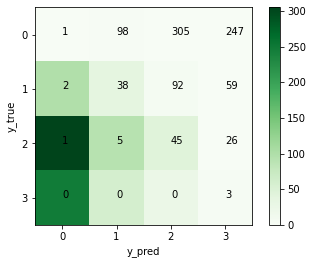

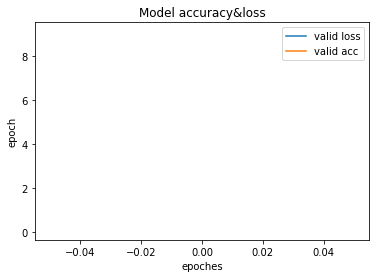

[sklearn_metrics] accuracy:0.0944 precision:0.0944 recall:0.0944 f1:0.0944


In [ ]:

test_preds = []
test_trues = []
eval_losses = []
eval_acces = []
criterion = nn.CrossEntropyLoss()
test_loss = 0
model_ft.eval()
with torch.no_grad():
  for i,(test_data_batch, test_data_label) in enumerate(test_loader):
    test_data_batch = test_data_batch.float().to(device) # 将double数据转换为float
    test_data_label = test_data_label.to(device)
    test_outputs = model_ft(test_data_batch)
    test_outputs = test_outputs.argmax(dim=1)
    test_preds.extend(test_outputs.detach().cpu().numpy())
    test_trues.extend(test_data_label.detach().cpu().numpy())
  sklearn_accuracy = accuracy_score(test_trues, test_preds) 
  sklearn_precision = precision_score(test_trues, test_preds, average='micro')
  sklearn_recall = recall_score(test_trues, test_preds, average='micro')
  sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
  print(classification_report(test_trues, test_preds))
  conf_matrix = get_confusion_matrix(test_trues, test_preds)
  print(conf_matrix)
  loss = criterion(test_outputs.float(), test_data_label.float())
  print_loss = loss.data.item()
  test_loss += print_loss
  avgloss = test_loss / len(test_loader)
  eval_losses.append(avgloss)
  eval_acces.append(sklearn_accuracy )
  plot_confusion_matrix(conf_matrix)
  plt.plot(np.arange(len(eval_losses)), eval_losses, label="valid loss")
  plt.plot(np.arange(len(eval_acces)), eval_acces, label="valid acc")
  plt.legend() #显示图例
  plt.xlabel('epoches')
  plt.ylabel("epoch")
  plt.title('Model accuracy&loss')
  plt.show()
  print("[sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

In [ ]:
test_outputs

NameError: ignored

In [ ]:
def get_acc_p_r_f1(trues, preds):
  labels = [0,1,2,3,]
  TP,FP,FN,TN = 0,0,0,0
  for label in labels:
    preds_tmp = np.array([1 if pred == label else 0 for pred in preds])
    trues_tmp = np.array([1 if true == label else 0 for true in trues])
    # print(preds_tmp, trues_tmp)
    # print()
    # TP预测为1真实为1
    # TN预测为0真实为0
    # FN预测为0真实为1
    # FP预测为1真实为0
    TP += ((preds_tmp == 1) & (trues_tmp == 1)).sum()
    TN += ((preds_tmp == 0) & (trues_tmp == 0)).sum()
    FN += ((preds_tmp == 0) & (trues_tmp == 1)).sum()
    FP += ((preds_tmp == 1) & (trues_tmp == 0)).sum()
  # print(TP, FP, FN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1 = 2 * precision * recall / (precision + recall)
  return precision, recall, f1

def get_acc(trues, preds):
  accuracy = (np.array(trues) == np.array(preds)).sum() / len(trues)
  return accuracy

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]] [[1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]]


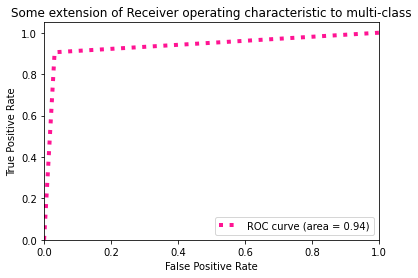

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
def get_roc_auc(trues, preds):
  labels = [0,1,2,3]
  nb_classes = len(labels)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  print(trues, preds)
  for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(trues.ravel(), preds.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  
  lw = 2
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],label='ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=4)
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.savefig("ROC_4分类.png")
  plt.show()
  
test_trues = label_binarize(test_trues, classes=[i for i in range(4)])
test_preds = label_binarize(test_preds, classes=[i for i in range(4)])
get_roc_auc(test_trues, test_preds)


In [ ]:
def get_p_r_f1_from_conf_matrix(conf_matrix):
  TP,FP,FN,TN = 0,0,0,0
  labels = [0,1,2,3]
  nums = len(labels)
  for i in labels:
    TP += conf_matrix[i, i]
    FP += (conf_matrix[:i, i].sum() + conf_matrix[i+1:, i].sum())
    FN += (conf_matrix[i, i+1:].sum() + conf_matrix[i, :i].sum())
  print(TP, FP, FN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1 = 2 * precision * recall / (precision + recall)
  return precision, recall, f1

def get_acc_from_conf_matrix(conf_matrix):
  labels = [0,1,2,3,]
  return sum([conf_matrix[i, i] for i in range(len(labels))]) / np.sum(np.sum(conf_matrix, axis=0))

  

In [ ]:

 

    model_ft.eval()

    result = []
    pos_posteriors = []
    neg_posteriors = []
    tp, tn, fp, fn = 0, 0, 0, 0
    y_pred = np.array([], dtype=np.float32)
    y_true = np.array([], dtype=np.int64)
    
    """
    # 特徴量のサイズを見るために使用
    img = Image.open(os.path.join(test_data_dir, fnames[0]))
    X = data_transform(img).expand((1, 3, width, height))
    X = X.to(device)
    out = model_ft(X)
    """
    
    labels_test = np.empty((len(sorted(glob.glob(test_data_dir + "*")))))
    num = 0
    
    for fname in tqdm(fnames):
        # calc posterior
        img = Image.open(os.path.join(fname))
        # バッチサイズ = 1なので、このままだと(3, width, height)になってしまう。
        # そのため、(1, 3, width, height)に形を変える。
        X = data_transform(img).expand((1, 3, width, height))
        X = X.to(device)
        out = model_ft(X)
        index = img_names_crowd.index(fname.split("/")[-1])
        labels_test[num] = labels_crowd[index]
        # そのままだと、gpuにデータがあるので、".detach().cpu()"でcpuに戻す。
        # tensor型なので、".numpy()"でnumpy形式に戻す。
        posterior = float(torch.nn.Softmax(dim=1)(out)[0, 1].detach().cpu().numpy())
        
        # 正例
        if labels_crowd[index] >= 0.5:  
            if posterior > 0.5:
                # true positive
                tp += 1
            else:
                # false negative
                fn += 1
            y_pred = np.hstack((y_pred, posterior))
            y_true = np.hstack((y_true, 1))
            result.append([fname, posterior, labels_crowd[index]])
            pos_posteriors.append(posterior)
        # 負例
        else:
            if posterior < 0.5:
                # true negative
                tn += 1
            else:
                # false positive
                fp += 1
            y_pred = np.hstack((y_pred, posterior))
            y_true = np.hstack((y_true, 0))
            result.append([fname, posterior, labels_crowd[index]])
            neg_posteriors.append(posterior)
            
        num += 1
    
    #
    # スコア計算・可視化
    #
    AUC = roc_auc_score(y_true, y_pred)
    Recall = recall_score(y_true, [0 if prob < 0.5 else 1 for prob in y_pred])
    Precision = precision_score(y_true, [0 if prob < 0.5 else 1 for prob in y_pred])
    F1 = f1_score(y_true, [0 if prob < 0.5 else 1 for prob in y_pred])
    
    print("tp, tn, fp, fn = [{}, {}, {}, {}]".format(tp, tn, fp, fn))
    print("\nAUC:{}, \nRecll:{}, \nPrecision:{}, \nF1:{}".format(round(AUC, 3), round(Recall, 3), round(Precision, 3), round(F1, 3)))
    
    # 棒グラフ作成
    fig, axes = plt.subplots(2, 1, figsize=(6, 10))
    
    for i in range(len(pos_posteriors)):
        if pos_posteriors[i]>1.0:
            pos_posteriors[i] = 0.99
        # 棒グラフを0.1刻みにしている。
        pos_posteriors[i] = math.floor(pos_posteriors[i]*10)/10
    for i in range(len(neg_posteriors)):
        if neg_posteriors[i]>1.0:
            neg_posteriors[i] = 0.99
        neg_posteriors[i] = math.floor(neg_posteriors[i]*10)/10

    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, int(graph_y_lim_pos))
    axes[0].hist(pos_posteriors, range=(0, 1), color="orange")

    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, int(graph_y_lim_neg))
    axes[1].hist(neg_posteriors, range=(0, 1))

    #fig.savefig(os.path.join(out_dir, "result.png"))
    plt.show()
    
    return result, y_true, y_pred